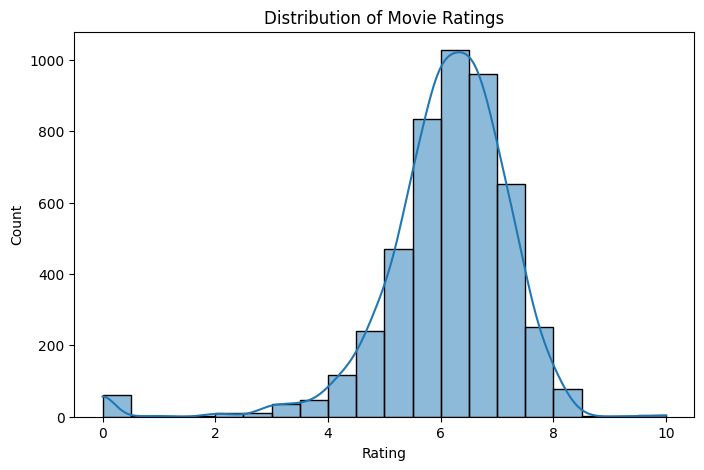

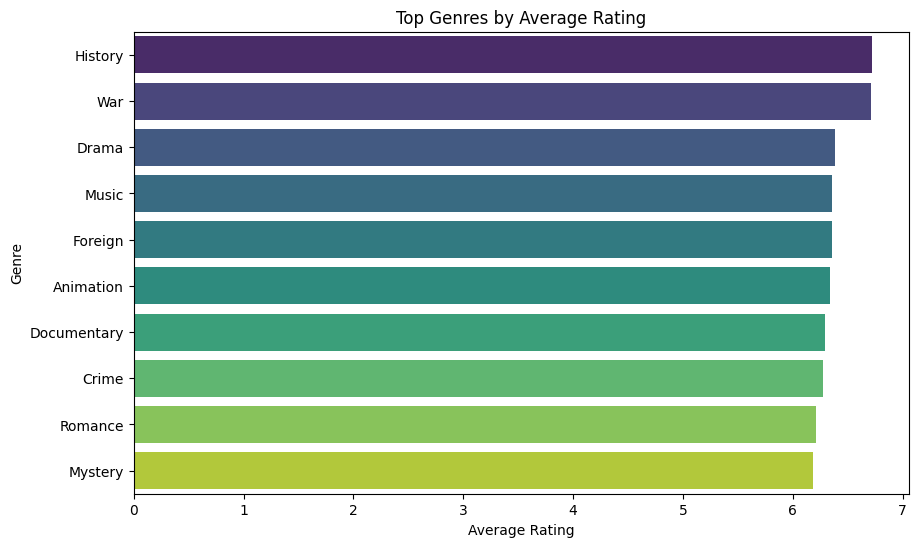

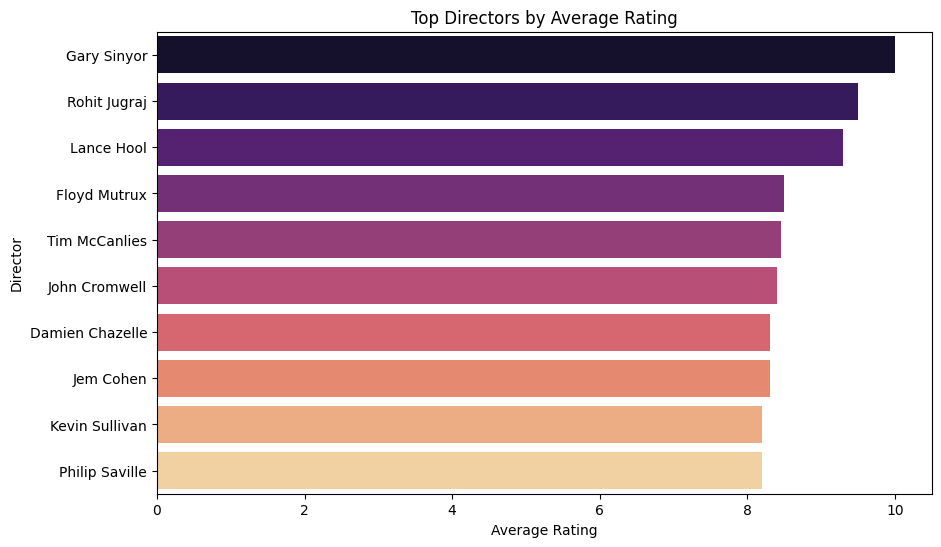


🎯 Model Evaluation:
MAE: 0.65
RMSE: 0.96

🎬 Random Movie Test
Title: Kangaroo Jack
Predicted Rating: 5.08
Actual Rating: 4.3


In [4]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

# Load datasets
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

# Merge datasets
data = movies.merge(credits, on='title')

# Select important columns
data = data[['title', 'genres', 'cast', 'crew', 'budget', 'revenue', 'runtime', 'vote_average']]

# Drop missing values
data.dropna(inplace=True)

# Helper functions
def parse_names(text):
    try:
        return [d['name'] for d in ast.literal_eval(text)]
    except:
        return []

def get_director(crew_str):
    try:
        crew = ast.literal_eval(crew_str)
        for person in crew:
            if person['job'] == 'Director':
                return person['name']
    except:
        return np.nan

# Apply parsing
data['genres'] = data['genres'].apply(parse_names)
data['cast'] = data['cast'].apply(parse_names)
data['director'] = data['crew'].apply(get_director)
data['cast'] = data['cast'].apply(lambda x: x[:3])

# Convert lists to strings
data['genres'] = data['genres'].apply(lambda x: " ".join(x))
data['cast'] = data['cast'].apply(lambda x: " ".join(x))
data['director'] = data['director'].fillna('').astype(str)

# Combine text columns
data['combined'] = data['genres'] + " " + data['cast'] + " " + data['director']

# ===== VISUALIZATION =====

plt.figure(figsize=(8, 5))
sns.histplot(data['vote_average'], bins=20, kde=True)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Average rating by top genres
genre_explode = data.copy()
genre_explode['genres_list'] = genre_explode['genres'].apply(lambda x: x.split())
genre_explode = genre_explode.explode('genres_list')

plt.figure(figsize=(10, 6))
top_genres = genre_explode.groupby('genres_list')['vote_average'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_genres.values, y=top_genres.index, palette="viridis")
plt.title("Top Genres by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()

# Average rating by top directors
top_directors = data.groupby('director')['vote_average'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_directors.values, y=top_directors.index, palette="magma")
plt.title("Top Directors by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Director")
plt.show()

# ===== MODELING =====

# Features and target
features = data[['budget', 'revenue', 'runtime', 'combined']]
target = data['vote_average']

# Text vectorization
cv = CountVectorizer(max_features=1000)
X_text = cv.fit_transform(features['combined']).toarray()

# Numeric scaling
scaler = StandardScaler()
X_numeric = scaler.fit_transform(features[['budget', 'revenue', 'runtime']])

# Final feature matrix
X = np.hstack((X_numeric, X_text))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n🎯 Model Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# ===== RANDOM TEST PREDICTION =====

import random

random_index = random.randint(0, len(data)-1)
random_movie = data.iloc[random_index]
print("\n🎬 Random Movie Test")
print("Title:", random_movie['title'])

# Prepare single prediction input
text_input = cv.transform([random_movie['combined']]).toarray()
numeric_input = scaler.transform([[random_movie['budget'], random_movie['revenue'], random_movie['runtime']]])
final_input = np.hstack((numeric_input, text_input))

predicted_rating = model.predict(final_input)[0]
actual_rating = random_movie['vote_average']

print(f"Predicted Rating: {predicted_rating:.2f}")
print(f"Actual Rating: {actual_rating}")


🎬 Movie Rating XGBoost Training
📁 Loading datasets...
✅ Loaded 4809 movies
🔧 Engineering features...
✅ Processed 4745 movies with complete data
🚀 Training XGBoost model...

🎯 Model Accuracy (MAE): 0.559


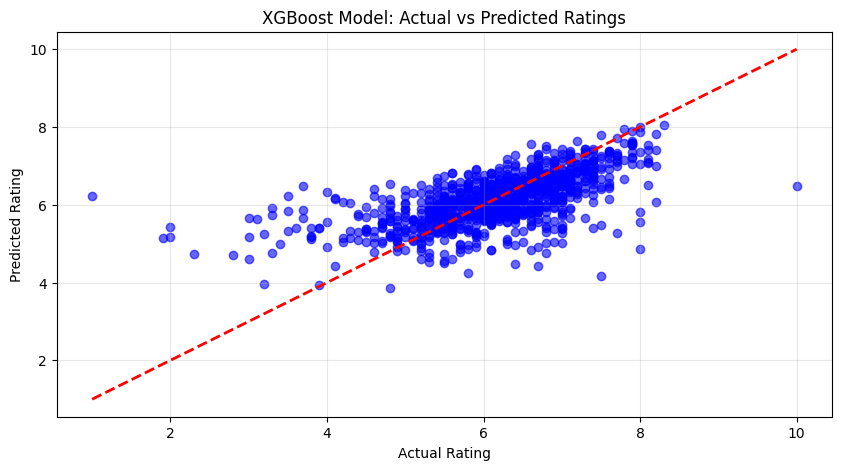

✅ Model saved as movie_rating_xgboost.pkl

📊 Final Results:
✅ Accuracy (MAE): 0.559
✅ Samples: 4745
✅ Features: 509

🎯 XGBoost model ready!


In [7]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

class MovieRatingModel:
    def __init__(self):
        self.model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        self.scaler = StandardScaler()
        self.vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
        self.feature_columns = None
        self.is_trained = False
        
    def parse_json_features(self, text):
        """Parse JSON-like strings from TMDB data"""
        try:
            parsed = ast.literal_eval(text)
            if isinstance(parsed, list):
                return [item['name'] for item in parsed if 'name' in item]
            return []
        except:
            return []
    
    def get_director(self, crew_str):
        """Extract director from crew data"""
        try:
            crew = ast.literal_eval(crew_str)
            for person in crew:
                if person.get('job') == 'Director':
                    return person.get('name', 'Unknown')
        except:
            pass
        return 'Unknown'
    
    def preprocess_data(self, movies_path, credits_path):
        """Load and preprocess the movie datasets"""
        print("📁 Loading datasets...")
        
        # Load datasets
        movies = pd.read_csv(movies_path)
        credits = pd.read_csv(credits_path)
        
        # Merge datasets
        data = movies.merge(credits, on='title', how='inner')
        print(f"✅ Loaded {len(data)} movies")
        
        # Select required columns
        required_cols = ['title', 'genres', 'cast', 'crew', 'budget', 'revenue', 
                        'runtime', 'vote_average', 'vote_count', 'popularity']
        data = data[required_cols].copy()
        
        # Remove movies with missing critical data
        data = data.dropna(subset=['vote_average', 'budget', 'revenue', 'runtime'])
        data = data[data['vote_average'] > 0]  # Remove movies with 0 rating
        
        print("🔧 Engineering features...")
        
        # Parse JSON columns
        data['genres_list'] = data['genres'].apply(self.parse_json_features)
        data['cast_list'] = data['cast'].apply(self.parse_json_features)
        data['director'] = data['crew'].apply(self.get_director)
        
        # Create text features
        data['genres_str'] = data['genres_list'].apply(lambda x: ' '.join(x[:3]))
        data['cast_str'] = data['cast_list'].apply(lambda x: ' '.join(x[:5]))
        data['combined_text'] = (data['genres_str'] + ' ' + 
                               data['cast_str'] + ' ' + 
                               data['director']).str.strip()
        
        # Create numeric features
        data['profit'] = data['revenue'] - data['budget']
        data['roi'] = np.where(data['budget'] > 0, data['profit'] / data['budget'], 0)
        data['log_budget'] = np.log1p(data['budget'])
        data['log_revenue'] = np.log1p(data['revenue'])
        data['log_popularity'] = np.log1p(data['popularity'])
        data['log_vote_count'] = np.log1p(data['vote_count'])
        data['num_genres'] = data['genres_list'].apply(len)
        data['num_cast'] = data['cast_list'].apply(len)
        
        # Define feature columns for consistency
        self.feature_columns = ['log_budget', 'log_revenue', 'runtime', 'log_popularity', 
                               'log_vote_count', 'profit', 'roi', 'num_genres', 'num_cast']
        
        print(f"✅ Processed {len(data)} movies with complete data")
        return data
    
    def prepare_features(self, data):
        """Prepare feature matrix for training"""
        # Numeric features
        X_numeric = data[self.feature_columns].values
        
        # Text features
        X_text = self.vectorizer.fit_transform(data['combined_text']).toarray()
        
        # Combine features
        X_combined = np.hstack([X_numeric, X_text])
        
        # Scale numeric features only (first 9 columns)
        X_scaled = X_combined.copy()
        X_scaled[:, :len(self.feature_columns)] = self.scaler.fit_transform(X_numeric)
        
        return X_scaled, data['vote_average'].values
    
    def plot_training_progress(self, y_test, y_pred):
        """Plot training results"""
        plt.figure(figsize=(10, 5))
        
        # Actual vs Predicted
        plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Rating')
        plt.ylabel('Predicted Rating')
        plt.title('XGBoost Model: Actual vs Predicted Ratings')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def train_model(self, movies_path, credits_path, test_size=0.2):
        """Complete training pipeline"""
        # Load and preprocess data
        data = self.preprocess_data(movies_path, credits_path)
        
        # Prepare features
        X, y = self.prepare_features(data)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        
        print("🚀 Training XGBoost model...")
        
        # Train model
        self.model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = self.model.predict(X_test)
        
        # Calculate accuracy metric (MAE only)
        mae = mean_absolute_error(y_test, y_pred)
        
        print(f"\n🎯 Model Accuracy (MAE): {mae:.3f}")
        
        # Plot training results
        self.plot_training_progress(y_test, y_pred)
        
        self.is_trained = True
        
        return {
            'mae': mae,
            'n_samples': len(data),
            'n_features': X.shape[1]
        }
    
    def save_model(self, filename='movie_rating_xgboost.pkl'):
        """Save the trained model and preprocessors"""
        if not self.is_trained:
            print("❌ Model not trained yet!")
            return
        
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'vectorizer': self.vectorizer,
            'feature_columns': self.feature_columns,
            'is_trained': self.is_trained
        }
        
        try:
            with open(filename, 'wb') as f:
                pickle.dump(model_data, f)
            print(f"✅ Model saved as {filename}")
        except Exception as e:
            print(f"❌ Error saving model: {e}")

# Training function for Jupyter Notebook
def train_movie_model():
    """Train the XGBoost model"""
    print("🎬 Movie Rating XGBoost Training")
    print("=" * 40)
    
    # Initialize model
    model = MovieRatingModel()
    
    # Train model
    try:
        results = model.train_model("tmdb_5000_movies.csv", "tmdb_5000_credits.csv")
        
        # Save model
        model.save_model("movie_rating_xgboost.pkl")
        
        print(f"\n📊 Final Results:")
        print(f"✅ Accuracy (MAE): {results['mae']:.3f}")
        print(f"✅ Samples: {results['n_samples']}")
        print(f"✅ Features: {results['n_features']}")
        print("\n🎯 XGBoost model ready!")
        
        return model
        
    except FileNotFoundError:
        print("❌ CSV files not found!")
        print("Ensure tmdb_5000_movies.csv and tmdb_5000_credits.csv are in the directory")
        return None
    except Exception as e:
        print(f"❌ Training error: {e}")
        return None

# Run this in Jupyter Notebook
if __name__ == "__main__":
    model = train_movie_model()

🎬 Enhanced Movie Rating Model Training
📁 Loading datasets...
✅ Loaded 4809 movies
🔧 Enhanced feature engineering...
✅ Enhanced processing: 4397 movies with 18 numeric features
🚀 Training enhanced model...
🔍 Hyperparameter tuning...
✅ Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
✅ Best CV MAE: 0.450

🎯 Enhanced Model Results:
✅ MAE: 0.446
✅ RMSE: 0.602
✅ R²: 0.563


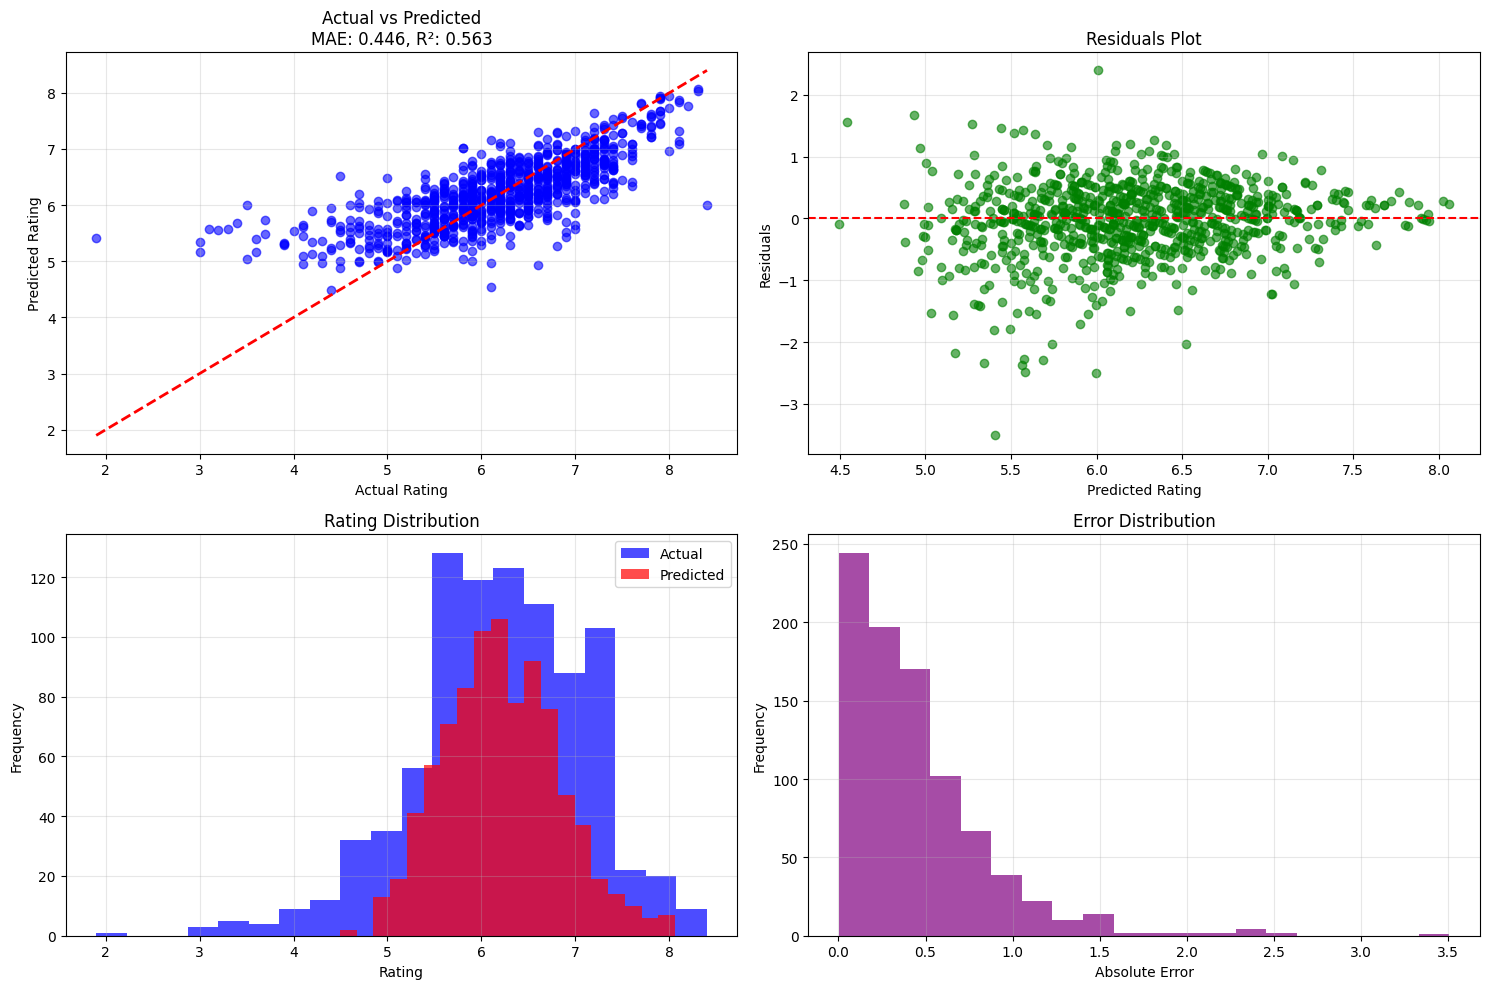

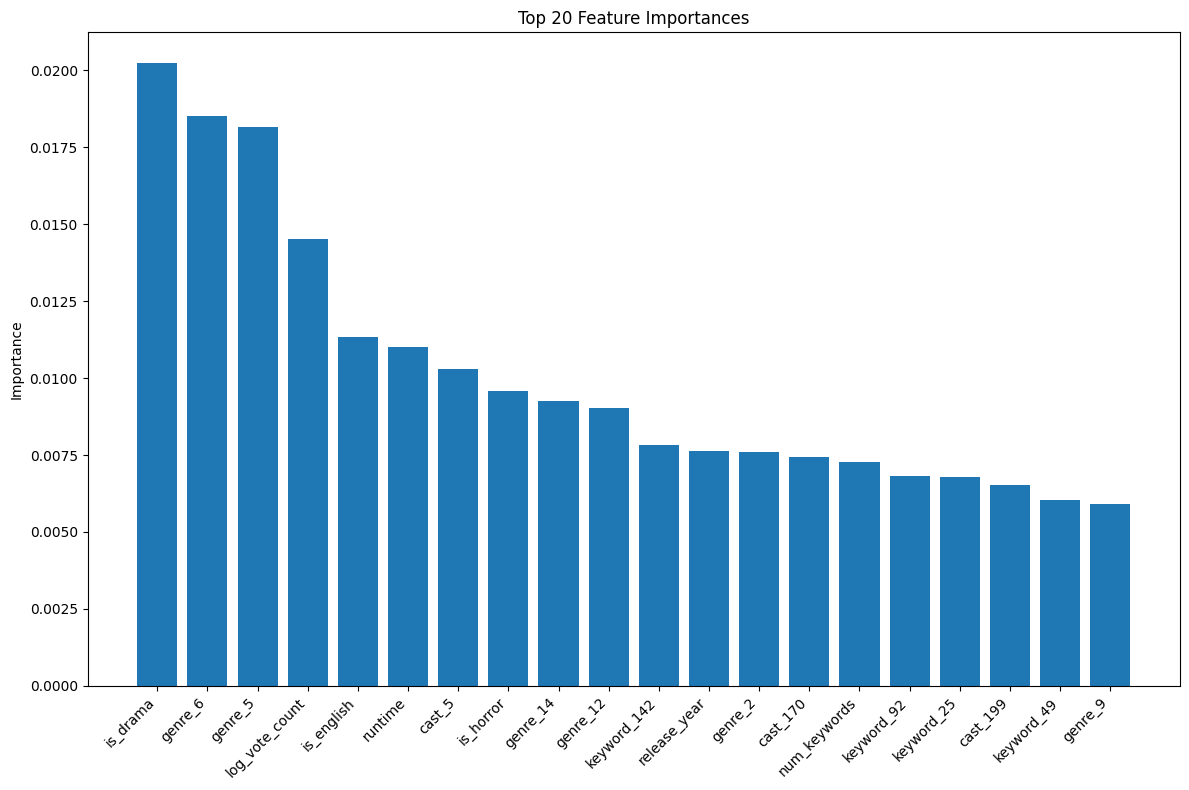

✅ Enhanced model saved as improved_movie_rating_model.pkl

📊 Final Enhanced Results:
✅ MAE: 0.446
✅ RMSE: 0.602
✅ R²: 0.563
✅ Samples: 4397
✅ Features: 391

🚀 Improvement over original: 0.113 MAE reduction


In [2]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import pickle
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

class ImprovedMovieRatingModel:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.genre_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
        self.cast_vectorizer = TfidfVectorizer(max_features=200, stop_words='english')
        self.keywords_vectorizer = TfidfVectorizer(max_features=150, stop_words='english')
        self.director_encoder = LabelEncoder()
        self.feature_columns = None
        self.is_trained = False
        
    def parse_json_features(self, text):
        """Parse JSON-like strings from TMDB data"""
        try:
            parsed = ast.literal_eval(text)
            if isinstance(parsed, list):
                return [item['name'] for item in parsed if 'name' in item]
            return []
        except:
            return []
    
    def get_director(self, crew_str):
        """Extract director from crew data"""
        try:
            crew = ast.literal_eval(crew_str)
            for person in crew:
                if person.get('job') == 'Director':
                    return person.get('name', 'Unknown')
        except:
            pass
        return 'Unknown'
    
    def extract_release_features(self, date_str):
        """Extract year, month, season from release date"""
        try:
            date_obj = pd.to_datetime(date_str)
            year = date_obj.year
            month = date_obj.month
            
            # Season mapping
            if month in [12, 1, 2]:
                season = 'Winter'
            elif month in [3, 4, 5]:
                season = 'Spring'
            elif month in [6, 7, 8]:
                season = 'Summer'
            else:
                season = 'Fall'
                
            return year, month, season
        except:
            return 2000, 1, 'Unknown'
    
    def preprocess_data(self, movies_path, credits_path):
        """Enhanced data preprocessing"""
        print("📁 Loading datasets...")
        
        # Load datasets
        movies = pd.read_csv(movies_path)
        credits = pd.read_csv(credits_path)
        
        # Merge datasets
        data = movies.merge(credits, on='title', how='inner')
        print(f"✅ Loaded {len(data)} movies")
        
        # Select columns that exist in your dataset
        required_cols = ['title', 'genres', 'cast', 'crew', 'budget', 'runtime', 
                        'vote_average', 'vote_count', 'popularity', 'release_date',
                        'original_language', 'keywords', 'overview', 'production_companies']
        
        # Only keep columns that actually exist
        available_cols = [col for col in required_cols if col in data.columns]
        data = data[available_cols].copy()
        
        # Remove movies with missing critical data
        data = data.dropna(subset=['vote_average', 'runtime'])
        data = data[data['vote_average'] > 0]  # Remove movies with 0 rating
        data = data[data['vote_count'] >= 10]  # Minimum vote threshold
        
        print("🔧 Enhanced feature engineering...")
        
        # Parse additional features from your dataset
        if 'keywords' in data.columns:
            data['keywords_list'] = data['keywords'].apply(self.parse_json_features)
            data['num_keywords'] = data['keywords_list'].apply(len)
            data['keywords_str'] = data['keywords_list'].apply(lambda x: ' '.join(x[:5]))
        else:
            data['num_keywords'] = 0
            data['keywords_str'] = ''
            
        if 'production_companies' in data.columns:
            data['prod_companies_list'] = data['production_companies'].apply(self.parse_json_features)
            data['num_prod_companies'] = data['prod_companies_list'].apply(len)
            # Check for major studios
            data['has_major_studio'] = data['prod_companies_list'].apply(
                lambda x: any(studio in str(x).lower() for studio in 
                            ['warner', 'disney', 'universal', 'paramount', 'sony', 'fox'])
            ).astype(int)
        else:
            data['num_prod_companies'] = 1
            data['has_major_studio'] = 0
        
        # Parse main JSON columns
        data['genres_list'] = data['genres'].apply(self.parse_json_features)
        data['cast_list'] = data['cast'].apply(self.parse_json_features)
        data['director'] = data['crew'].apply(self.get_director)
        
        # Release date features
        data['release_year'], data['release_month'], data['release_season'] = zip(
            *data['release_date'].apply(self.extract_release_features)
        )
        
        # Budget features (handle missing values better)
        data['budget'] = data['budget'].fillna(0)
        data['has_budget'] = (data['budget'] > 0).astype(int)
        data['log_budget'] = np.where(data['budget'] > 0, np.log1p(data['budget']), 0)
        
        # Popularity and vote features
        data['log_popularity'] = np.log1p(data['popularity'])
        data['log_vote_count'] = np.log1p(data['vote_count'])
        data['popularity_per_vote'] = data['popularity'] / (data['vote_count'] + 1)
        
        # Runtime features
        data['runtime_category'] = pd.cut(data['runtime'], 
                                        bins=[0, 90, 120, 150, 300], 
                                        labels=['Short', 'Medium', 'Long', 'Epic'])
        
        # Genre features
        data['num_genres'] = data['genres_list'].apply(len)
        data['is_action'] = data['genres_list'].apply(lambda x: 'Action' in x).astype(int)
        data['is_comedy'] = data['genres_list'].apply(lambda x: 'Comedy' in x).astype(int)
        data['is_drama'] = data['genres_list'].apply(lambda x: 'Drama' in x).astype(int)
        data['is_horror'] = data['genres_list'].apply(lambda x: 'Horror' in x).astype(int)
        
        # Cast features
        data['num_cast'] = data['cast_list'].apply(len)
        data['cast_str'] = data['cast_list'].apply(lambda x: ' '.join(x[:10]))  # More cast members
        
        # Text features
        data['genres_str'] = data['genres_list'].apply(lambda x: ' '.join(x))
        
        # Language features
        data['is_english'] = (data['original_language'] == 'en').astype(int)
        
        # Define feature columns that work with your dataset
        self.feature_columns = [
            'log_budget', 'has_budget', 'runtime', 'log_popularity', 
            'log_vote_count', 'popularity_per_vote', 'num_genres', 'num_cast',
            'release_year', 'release_month', 'is_action', 'is_comedy', 
            'is_drama', 'is_horror', 'is_english', 'num_keywords',
            'num_prod_companies', 'has_major_studio'
        ]
        
        print(f"✅ Enhanced processing: {len(data)} movies with {len(self.feature_columns)} numeric features")
        return data
    
    def prepare_features(self, data, is_training=True):
        """Enhanced feature preparation"""
        # Numeric features
        X_numeric = data[self.feature_columns].values
        
        # Text features - separate vectorizers for genres, cast, and keywords
        if is_training:
            X_genres = self.genre_vectorizer.fit_transform(data['genres_str']).toarray()
            X_cast = self.cast_vectorizer.fit_transform(data['cast_str']).toarray()
            X_keywords = self.keywords_vectorizer.fit_transform(data['keywords_str']).toarray()
            
            # Director encoding
            self.director_encoder.fit(data['director'])
        else:
            X_genres = self.genre_vectorizer.transform(data['genres_str']).toarray()
            X_cast = self.cast_vectorizer.transform(data['cast_str']).toarray()
            X_keywords = self.keywords_vectorizer.transform(data['keywords_str']).toarray()
        
        X_director = self.director_encoder.transform(data['director']).reshape(-1, 1)
        
        # Combine all features
        X_combined = np.hstack([X_numeric, X_genres, X_cast, X_keywords, X_director])
        
        # Scale numeric features only
        if is_training:
            X_scaled = X_combined.copy()
            X_scaled[:, :len(self.feature_columns)] = self.scaler.fit_transform(X_numeric)
        else:
            X_scaled = X_combined.copy()
            X_scaled[:, :len(self.feature_columns)] = self.scaler.transform(X_numeric)
        
        return X_scaled, data['vote_average'].values
    
    def train_with_hyperparameter_tuning(self, X_train, y_train):
        """Train with hyperparameter optimization"""
        print("🔍 Hyperparameter tuning...")
        
        # XGBoost parameter grid
        xgb_params = {
            'n_estimators': [100, 200, 300],
            'max_depth': [4, 6, 8],
            'learning_rate': [0.05, 0.1, 0.15],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        }
        
        base_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
        
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            base_model, xgb_params, 
            cv=3, scoring='neg_mean_absolute_error',
            n_jobs=-1, verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        
        print(f"✅ Best parameters: {grid_search.best_params_}")
        print(f"✅ Best CV MAE: {-grid_search.best_score_:.3f}")
        
        return grid_search.best_estimator_
    
    def plot_enhanced_results(self, y_test, y_pred, mae, r2):
        """Enhanced visualization"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Actual vs Predicted
        axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='blue')
        axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0,0].set_xlabel('Actual Rating')
        axes[0,0].set_ylabel('Predicted Rating')
        axes[0,0].set_title(f'Actual vs Predicted\nMAE: {mae:.3f}, R²: {r2:.3f}')
        axes[0,0].grid(True, alpha=0.3)
        
        # Residuals plot
        residuals = y_test - y_pred
        axes[0,1].scatter(y_pred, residuals, alpha=0.6, color='green')
        axes[0,1].axhline(y=0, color='r', linestyle='--')
        axes[0,1].set_xlabel('Predicted Rating')
        axes[0,1].set_ylabel('Residuals')
        axes[0,1].set_title('Residuals Plot')
        axes[0,1].grid(True, alpha=0.3)
        
        # Distribution of actual ratings
        axes[1,0].hist(y_test, bins=20, alpha=0.7, color='blue', label='Actual')
        axes[1,0].hist(y_pred, bins=20, alpha=0.7, color='red', label='Predicted')
        axes[1,0].set_xlabel('Rating')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Rating Distribution')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Error distribution
        axes[1,1].hist(np.abs(residuals), bins=20, alpha=0.7, color='purple')
        axes[1,1].set_xlabel('Absolute Error')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Error Distribution')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def train_model(self, movies_path, credits_path, test_size=0.2, tune_hyperparams=True):
        """Complete enhanced training pipeline"""
        # Load and preprocess data
        data = self.preprocess_data(movies_path, credits_path)
        
        # Prepare features
        X, y = self.prepare_features(data, is_training=True)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        
        print("🚀 Training enhanced model...")
        
        # Train with or without hyperparameter tuning
        if tune_hyperparams:
            self.model = self.train_with_hyperparameter_tuning(X_train, y_train)
        else:
            self.model = xgb.XGBRegressor(
                n_estimators=200, max_depth=6, learning_rate=0.1,
                subsample=0.9, colsample_bytree=0.9,
                random_state=42, n_jobs=-1
            )
            self.model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = self.model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        print(f"\n🎯 Enhanced Model Results:")
        print(f"✅ MAE: {mae:.3f}")
        print(f"✅ RMSE: {rmse:.3f}")
        print(f"✅ R²: {r2:.3f}")
        
        # Enhanced plotting
        self.plot_enhanced_results(y_test, y_pred, mae, r2)
        
        # Feature importance
        self.plot_feature_importance()
        
        self.is_trained = True
        
        return {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'n_samples': len(data),
            'n_features': X.shape[1]
        }
    
    def plot_feature_importance(self, top_n=20):
        """Plot feature importance"""
        if hasattr(self.model, 'feature_importances_'):
            importance = self.model.feature_importances_
            
            # Create feature names
            feature_names = (self.feature_columns + 
                           [f'genre_{i}' for i in range(len(self.genre_vectorizer.get_feature_names_out()))] +
                           [f'cast_{i}' for i in range(len(self.cast_vectorizer.get_feature_names_out()))] +
                           [f'keyword_{i}' for i in range(len(self.keywords_vectorizer.get_feature_names_out()))] +
                           ['director'])
            
            # Get top features
            indices = np.argsort(importance)[::-1][:top_n]
            
            plt.figure(figsize=(12, 8))
            plt.bar(range(top_n), importance[indices])
            plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=45, ha='right')
            plt.title(f'Top {top_n} Feature Importances')
            plt.ylabel('Importance')
            plt.tight_layout()
            plt.show()
    
    def save_model(self, filename='improved_movie_rating_model.pkl'):
        """Save the enhanced model"""
        if not self.is_trained:
            print("❌ Model not trained yet!")
            return
        
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'genre_vectorizer': self.genre_vectorizer,
            'cast_vectorizer': self.cast_vectorizer,
            'keywords_vectorizer': self.keywords_vectorizer,
            'director_encoder': self.director_encoder,
            'feature_columns': self.feature_columns,
            'is_trained': self.is_trained
        }
        
        try:
            with open(filename, 'wb') as f:
                pickle.dump(model_data, f)
            print(f"✅ Enhanced model saved as {filename}")
        except Exception as e:
            print(f"❌ Error saving model: {e}")

def train_improved_model(tune_hyperparams=True):
    """Train the improved model"""
    print("🎬 Enhanced Movie Rating Model Training")
    print("=" * 50)
    
    model = ImprovedMovieRatingModel()
    
    try:
        results = model.train_model(
            "tmdb_5000_movies.csv", 
            "tmdb_5000_credits.csv",
            tune_hyperparams=tune_hyperparams
        )
        
        model.save_model("improved_movie_rating_model.pkl")
        
        print(f"\n📊 Final Enhanced Results:")
        print(f"✅ MAE: {results['mae']:.3f}")
        print(f"✅ RMSE: {results['rmse']:.3f}")
        print(f"✅ R²: {results['r2']:.3f}")
        print(f"✅ Samples: {results['n_samples']}")
        print(f"✅ Features: {results['n_features']}")
        
        improvement = 0.559 - results['mae']
        print(f"\n🚀 Improvement over original: {improvement:.3f} MAE reduction")
        
        return model
        
    except Exception as e:
        print(f"❌ Training error: {e}")
        return None

# Run the improved model
if __name__ == "__main__":
    model = train_improved_model(tune_hyperparams=True)